<a href="https://colab.research.google.com/github/SaketMunda/transfer-learning-with-tensorflow/blob/master/exercises_fine_tuning_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises for Fine-Tuning Transfer Learning with TensorFlow

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [tf.keras.applications.EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

## Exercise - 1

**Problem Definition**:

Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [tf.keras.applications.EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.


### Load Data

For this exercise we'll be taking a food 101 dataset from this directory : https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

First, let's import the **helper functions** to unzip the data and walk through the directories,

In [1]:
# Get helper_functions.py script from Github
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves

--2023-01-03 07:00:13--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-03 07:00:13 (43.8 MB/s) - ‘helper_functions.py’ saved [2904/2904]



In [2]:
# download the zip file into runtime
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the data
unzip_data("10_food_classes_10_percent.zip")

# walking through the extracted zip file
walk_through_dir("10_food_classes_10_percent")

--2023-01-03 07:00:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   156MB/s    in 1.0s    

2023-01-03 07:00:21 (156 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 files in '10_food_classes_10_percent'
There are 10 directories and 0 files in '10_food_classes_10_percent/test'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 files in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 files in '10_food_classes

### Create data loaders (prepare data)

We need to create data loaders using `image_dataset_from_directory()` from `tf.keras.preprocessing` for train and test images

In [3]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SHAPE = (224, 224)

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SHAPE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Create ModelCheckpoints

Create ModelCheckpoints to save the weights of the model

In [4]:
# setup checkpoint path
checkpoint_path = '10_percent_model_checkpoints_weights/checkpoint.ckpt'

# create a modelchecpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

### Build a feature extraction model using Keras Functional API

In [5]:
initial_epochs = 10

# 1. Create a base model using tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create the inputs into the base model
inputs = tf.keras.layers.Input(shape=IMG_SHAPE + (3,), name='input_layer')

# 4. Pass the inputs to the model
x = base_model(inputs)

# 5. Average pool the outputs of the base_model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 7. Combine the inputs and outputs into our model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# 9. Fit the model
history_model_0 = model_0.fit(train_data_10_percent,
                            epochs=initial_epochs,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data,
                            validation_steps=int(0.25 * len(test_data)),
                            callbacks=[checkpoint_callback])

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8331 - accuracy: 0.4573
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 326ms/step - loss: 1.8331 - accuracy: 0.4573 - val_loss: 1.2750 - val_accuracy: 0.7582
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.0838 - accuracy: 0.7677
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 5s 182ms/step - loss: 1.0782 - accuracy: 0.7693 - val_loss: 0.8625 - val_accuracy: 0.8158
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7792 - accuracy: 0.8193
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 171ms/step - loss: 0.7724 - accuracy: 0.8227 - val_loss: 0.6760 - val_accuracy: 0.8520
Epoch 4/10
23/24 [=======

## Exercise 2 

**Problem Definition**:

Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?



### Unfreeze last 20 layers

Since all the layers of our `base_model` is frozen in the Exercise 1, we have to unfreeze them in order to train it for another 10 epochs.

In [6]:
# check all the layers of our model
for layer_number, layers in enumerate(model_0.layers):
  print(layer_number, layers.name, layers.trainable)

0 input_layer True
1 efficientnetb0 False
2 global_average_pooling_layer True
3 output_layer True


In [7]:
# check the layers of base_model i.e model_0.layers[1]
for layer_number, layers in enumerate(base_model.layers):
  print(layer_number, layers.name, layers.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

From above number of layers, we've to unfreeze the last 20 layers and make them trainable for fine-tuning.

In [8]:
# make the model trainable
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

Now again checking the layers which are trainable from base_model

In [9]:
for layer_number, layers in enumerate(base_model.layers):
  print(layer_number, layers.name, layers.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Great ! Let's re-compile the `model_0` and train it for another 10 epochs

### Train for Another 10 epochs

In [10]:
fine_tune_10_epochs = initial_epochs + 10

# compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# train the model
history_another_10_epoch = model_0.fit(train_data_10_percent,
                                       epochs=fine_tune_10_epochs,
                                       validation_data=test_data,
                                       initial_epoch=history_model_0.epoch[-1],
                                       validation_steps=int(0.25 * len(test_data)))

Epoch 10/20
24/24 [==============================] - 13s 226ms/step - loss: 0.5670 - accuracy: 0.8347 - val_loss: 0.6271 - val_accuracy: 0.8207
Epoch 11/20
24/24 [==============================] - 5s 192ms/step - loss: 0.1091 - accuracy: 0.9747 - val_loss: 0.4876 - val_accuracy: 0.8684
Epoch 12/20
24/24 [==============================] - 4s 165ms/step - loss: 0.0396 - accuracy: 0.9947 - val_loss: 0.4619 - val_accuracy: 0.8734
Epoch 13/20
24/24 [==============================] - 4s 167ms/step - loss: 0.0258 - accuracy: 0.9987 - val_loss: 0.4660 - val_accuracy: 0.8635
Epoch 14/20
24/24 [==============================] - 5s 180ms/step - loss: 0.0184 - accuracy: 0.9987 - val_loss: 0.4322 - val_accuracy: 0.8750
Epoch 15/20
24/24 [==============================] - 4s 166ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.4668 - val_accuracy: 0.8684
Epoch 16/20
24/24 [==============================] - 4s 163ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.3767 - val_accuracy: 0.896

## Exercise 3

**Problem Definition**:

Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?

### Unfreeze last 30 layers

In [11]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

### Train for Another 10 epochs

In [12]:
fine_tune_last_30_layers = initial_epochs + 10

# compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# train the model
history_another_10_epoch_30_layers = model_0.fit(train_data_10_percent,
                                       epochs=fine_tune_last_30_layers,
                                       validation_data=test_data,
                                       initial_epoch=history_model_0.epoch[-1],
                                       validation_steps=int(0.25 * len(test_data)))

Epoch 10/20
24/24 [==============================] - 11s 222ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.4678 - val_accuracy: 0.8668
Epoch 11/20
24/24 [==============================] - 5s 187ms/step - loss: 0.0476 - accuracy: 0.9893 - val_loss: 0.5607 - val_accuracy: 0.8470
Epoch 12/20
24/24 [==============================] - 5s 181ms/step - loss: 0.0405 - accuracy: 0.9880 - val_loss: 0.6815 - val_accuracy: 0.8503
Epoch 13/20
24/24 [==============================] - 6s 228ms/step - loss: 0.0346 - accuracy: 0.9920 - val_loss: 0.6067 - val_accuracy: 0.8503
Epoch 14/20
24/24 [==============================] - 5s 174ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.6187 - val_accuracy: 0.8503
Epoch 15/20
24/24 [==============================] - 4s 167ms/step - loss: 0.0275 - accuracy: 0.9920 - val_loss: 0.7244 - val_accuracy: 0.8421
Epoch 16/20
24/24 [==============================] - 4s 167ms/step - loss: 0.0578 - accuracy: 0.9827 - val_loss: 0.7333 - val_accuracy: 0.856

## Exercise 4

**Problem Definition**:

Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

So now we have a trained model i.e `model_0`, we can use this model to prediction.  

In [13]:
# evaluating the model on test data
results_exercise_3 = model_0.evaluate(test_data)
results_exercise_3

79/79 [==============================] - 7s 85ms/step - loss: 0.6954 - accuracy: 0.8556


[0.6953793168067932, 0.8555999994277954]

In [33]:
# let's do some prediction,
image_batch, label_batch = test_data.as_numpy_iterator().next()
y_pred = model_0.predict(tf.expand_dims(image_batch[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [34]:
import numpy as np
test_data.class_names[np.argmax(y_pred)]

'chicken_wings'

In [35]:
y_pred

array([[6.40438647e-10, 9.99999285e-01, 1.02358451e-08, 5.73301513e-08,
        2.44170792e-07, 2.63610161e-10, 1.74567575e-07, 6.60257439e-12,
        5.25306909e-08, 1.06134955e-07]], dtype=float32)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_and_predict(dataset, model):
  """
  Function to visualize the images and display the model's predicted
  labels and it's probabilities
  """

  image_batch, label_batch = dataset.as_numpy_iterator().next()
  batch_probs = [model.predict(tf.expand_dims(img, axis=0), verbose=0) for img in image_batch]
  batch_preds = [dataset.class_names[np.argmax(prob)] for prob in batch_probs]

  plt.figure(figsize=(20,10))

  for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    if dataset.class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      color = 'g'
    else:
      color = 'r'
    
    plt.title(f'actual : {dataset.class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_probs[i].max():.2f}', c=color)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.axis('off');
    #plt.figure();


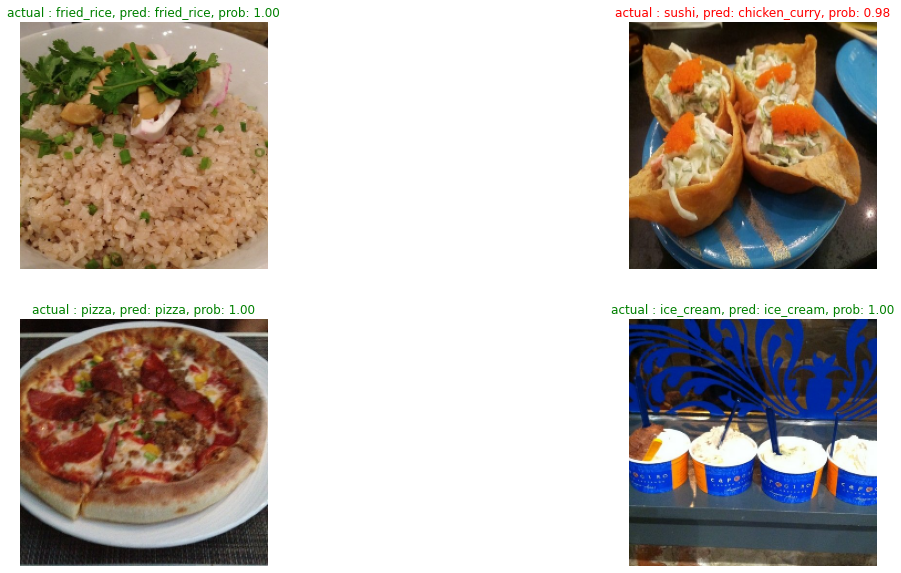

In [45]:
visualize_and_predict(test_data, model_0)